# Finetuning Performance Comparison Between Supervised and Self-supervised Pretrained Models
In this notebook, we compare the transfer learning performances of two pretrained models:
1. Supervised pretrained classification model.
2. Self-supervsied pretrained model using SimSiam.

Both pretrained models are trained on ImageNet dataset with a ResNet-50 backbone. 
For fair comparisons, we finetune two models with same hyperparameters (learning rate and epochs). 
For both pretrained model, we adopt a linear-probing evaluation, which means we only train the added linear layer for classification prediction and freeze the pretrained backbone. 
Therefore, output features of pretrained models can be di

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torchvision.models import resnet50

from data import get_bloodmnist_loader
from utils import *

!nvidia-smi

Fri Nov 29 17:54:29 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:06:00.0 Off |                    0 |
| N/A   53C    P0    30W /  70W |   7789MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
num_classes = 8
train_loader = get_bloodmnist_loader(split='train', batch_size=64, shuffle=True)
val_loader = get_bloodmnist_loader(split='val', batch_size=100, shuffle=False)
test_loader = get_bloodmnist_loader(split='test', batch_size=100, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using downloaded and verified file: /h/lkcai/.medmnist/bloodmnist_128.npz
Using downloaded and verified file: /h/lkcai/.medmnist/bloodmnist_128.npz
Using downloaded and verified file: /h/lkcai/.medmnist/bloodmnist_128.npz


# Linear Probing with ImageNet supervised pretrained backbone

In [4]:
sup_model = resnet50(pretrained=True)
for name, param in sup_model.named_parameters():
    if name not in ["fc.weight", "fc.bias"]:
        param.requires_grad = False

sup_model.fc = nn.Linear(sup_model.fc.in_features, num_classes)
sup_model.fc.weight.data.normal_(mean=0.0, std=0.01)
sup_model.fc.bias.data.zero_()
sup_model = sup_model.to(device)

parameters = list(filter(lambda p: p.requires_grad, sup_model.parameters()))
optimizer = optim.SGD(parameters, 0.001, momentum=0.9, weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()

val_acc = validate(sup_model, val_loader, device)
print(f"Pretrained Classifier with Random head - Val Acc: {val_acc:.2f}% ")

Pretrained Classifier with Random head - Val Acc: 11.97% 


100%|██████████| 187/187 [01:14<00:00,  2.50it/s]


[Epoch 1/50]: Train Loss: 1.3600 Train Acc: 57.88% | Val Acc: 54.79%


100%|██████████| 187/187 [01:14<00:00,  2.50it/s]


[Epoch 2/50]: Train Loss: 0.8776 Train Acc: 75.56% | Val Acc: 65.07%


100%|██████████| 187/187 [01:14<00:00,  2.51it/s]


[Epoch 3/50]: Train Loss: 0.7455 Train Acc: 78.55% | Val Acc: 72.66%


100%|██████████| 187/187 [01:14<00:00,  2.49it/s]


[Epoch 4/50]: Train Loss: 0.6731 Train Acc: 79.72% | Val Acc: 73.66%


100%|██████████| 187/187 [01:15<00:00,  2.47it/s]


[Epoch 5/50]: Train Loss: 0.6271 Train Acc: 81.32% | Val Acc: 76.64%


100%|██████████| 187/187 [01:14<00:00,  2.50it/s]


[Epoch 6/50]: Train Loss: 0.6061 Train Acc: 81.22% | Val Acc: 76.34%


100%|██████████| 187/187 [01:14<00:00,  2.51it/s]


[Epoch 7/50]: Train Loss: 0.5848 Train Acc: 81.61% | Val Acc: 77.04%


100%|██████████| 187/187 [01:15<00:00,  2.47it/s]


[Epoch 8/50]: Train Loss: 0.5687 Train Acc: 82.06% | Val Acc: 77.80%


100%|██████████| 187/187 [01:14<00:00,  2.49it/s]


[Epoch 9/50]: Train Loss: 0.5451 Train Acc: 82.70% | Val Acc: 82.07%


100%|██████████| 187/187 [01:14<00:00,  2.49it/s]


[Epoch 10/50]: Train Loss: 0.5347 Train Acc: 83.23% | Val Acc: 79.32%


100%|██████████| 187/187 [01:15<00:00,  2.49it/s]


[Epoch 11/50]: Train Loss: 0.5251 Train Acc: 83.23% | Val Acc: 81.31%


100%|██████████| 187/187 [01:15<00:00,  2.49it/s]


[Epoch 12/50]: Train Loss: 0.5264 Train Acc: 83.49% | Val Acc: 82.01%


100%|██████████| 187/187 [01:15<00:00,  2.49it/s]


[Epoch 13/50]: Train Loss: 0.5108 Train Acc: 83.82% | Val Acc: 81.83%


100%|██████████| 187/187 [01:15<00:00,  2.49it/s]


[Epoch 14/50]: Train Loss: 0.4977 Train Acc: 83.79% | Val Acc: 81.66%


100%|██████████| 187/187 [01:14<00:00,  2.50it/s]


[Epoch 15/50]: Train Loss: 0.5015 Train Acc: 83.43% | Val Acc: 81.02%


100%|██████████| 187/187 [01:15<00:00,  2.49it/s]


[Epoch 16/50]: Train Loss: 0.5070 Train Acc: 83.44% | Val Acc: 83.41%


100%|██████████| 187/187 [01:14<00:00,  2.50it/s]


[Epoch 17/50]: Train Loss: 0.4813 Train Acc: 84.55% | Val Acc: 83.47%


100%|██████████| 187/187 [01:14<00:00,  2.49it/s]


[Epoch 18/50]: Train Loss: 0.4862 Train Acc: 84.00% | Val Acc: 82.24%


100%|██████████| 187/187 [01:15<00:00,  2.48it/s]


[Epoch 19/50]: Train Loss: 0.4792 Train Acc: 84.37% | Val Acc: 81.13%


100%|██████████| 187/187 [01:14<00:00,  2.50it/s]


[Epoch 20/50]: Train Loss: 0.4786 Train Acc: 84.42% | Val Acc: 84.52%


100%|██████████| 187/187 [01:15<00:00,  2.49it/s]


[Epoch 21/50]: Train Loss: 0.4698 Train Acc: 84.56% | Val Acc: 83.94%


100%|██████████| 187/187 [01:14<00:00,  2.49it/s]


[Epoch 22/50]: Train Loss: 0.4704 Train Acc: 84.65% | Val Acc: 83.94%


100%|██████████| 187/187 [01:15<00:00,  2.49it/s]


[Epoch 23/50]: Train Loss: 0.4607 Train Acc: 84.86% | Val Acc: 83.88%


100%|██████████| 187/187 [01:14<00:00,  2.50it/s]


[Epoch 24/50]: Train Loss: 0.4580 Train Acc: 84.76% | Val Acc: 85.40%


100%|██████████| 187/187 [01:14<00:00,  2.50it/s]


[Epoch 25/50]: Train Loss: 0.4663 Train Acc: 84.71% | Val Acc: 84.99%


100%|██████████| 187/187 [01:15<00:00,  2.49it/s]


[Epoch 26/50]: Train Loss: 0.4604 Train Acc: 84.95% | Val Acc: 83.53%


100%|██████████| 187/187 [01:15<00:00,  2.48it/s]


[Epoch 27/50]: Train Loss: 0.4531 Train Acc: 84.92% | Val Acc: 84.75%


100%|██████████| 187/187 [01:14<00:00,  2.50it/s]


[Epoch 28/50]: Train Loss: 0.4560 Train Acc: 84.89% | Val Acc: 84.29%


100%|██████████| 187/187 [01:15<00:00,  2.48it/s]


[Epoch 29/50]: Train Loss: 0.4464 Train Acc: 85.39% | Val Acc: 84.11%


100%|██████████| 187/187 [01:14<00:00,  2.50it/s]


[Epoch 30/50]: Train Loss: 0.4419 Train Acc: 84.95% | Val Acc: 85.05%


100%|██████████| 187/187 [01:16<00:00,  2.43it/s]


[Epoch 31/50]: Train Loss: 0.4361 Train Acc: 85.86% | Val Acc: 84.81%


100%|██████████| 187/187 [01:14<00:00,  2.49it/s]


[Epoch 32/50]: Train Loss: 0.4511 Train Acc: 85.09% | Val Acc: 85.46%


100%|██████████| 187/187 [01:15<00:00,  2.48it/s]


[Epoch 33/50]: Train Loss: 0.4379 Train Acc: 85.38% | Val Acc: 85.81%


100%|██████████| 187/187 [01:15<00:00,  2.47it/s]


[Epoch 34/50]: Train Loss: 0.4444 Train Acc: 85.45% | Val Acc: 84.46%


100%|██████████| 187/187 [01:15<00:00,  2.47it/s]


[Epoch 35/50]: Train Loss: 0.4370 Train Acc: 85.73% | Val Acc: 84.40%


100%|██████████| 187/187 [01:15<00:00,  2.49it/s]


[Epoch 36/50]: Train Loss: 0.4406 Train Acc: 85.33% | Val Acc: 84.70%


100%|██████████| 187/187 [01:15<00:00,  2.49it/s]


[Epoch 37/50]: Train Loss: 0.4351 Train Acc: 85.45% | Val Acc: 85.69%


100%|██████████| 187/187 [01:15<00:00,  2.49it/s]


[Epoch 38/50]: Train Loss: 0.4248 Train Acc: 85.95% | Val Acc: 86.33%


100%|██████████| 187/187 [01:16<00:00,  2.46it/s]


[Epoch 39/50]: Train Loss: 0.4356 Train Acc: 85.70% | Val Acc: 84.81%


100%|██████████| 187/187 [01:16<00:00,  2.43it/s]


[Epoch 40/50]: Train Loss: 0.4259 Train Acc: 85.83% | Val Acc: 85.22%


100%|██████████| 187/187 [01:16<00:00,  2.44it/s]


[Epoch 41/50]: Train Loss: 0.4315 Train Acc: 85.90% | Val Acc: 85.11%


100%|██████████| 187/187 [01:15<00:00,  2.47it/s]


[Epoch 42/50]: Train Loss: 0.4204 Train Acc: 85.85% | Val Acc: 84.23%


100%|██████████| 187/187 [01:16<00:00,  2.46it/s]


[Epoch 43/50]: Train Loss: 0.4278 Train Acc: 85.75% | Val Acc: 85.92%


100%|██████████| 187/187 [01:15<00:00,  2.47it/s]


[Epoch 44/50]: Train Loss: 0.4324 Train Acc: 85.90% | Val Acc: 85.51%


100%|██████████| 187/187 [01:15<00:00,  2.47it/s]


[Epoch 45/50]: Train Loss: 0.4252 Train Acc: 85.78% | Val Acc: 84.87%


100%|██████████| 187/187 [01:15<00:00,  2.47it/s]


[Epoch 46/50]: Train Loss: 0.4275 Train Acc: 85.77% | Val Acc: 86.27%


100%|██████████| 187/187 [01:15<00:00,  2.47it/s]


[Epoch 47/50]: Train Loss: 0.4302 Train Acc: 85.53% | Val Acc: 86.97%


100%|██████████| 187/187 [01:14<00:00,  2.50it/s]


[Epoch 48/50]: Train Loss: 0.4023 Train Acc: 86.79% | Val Acc: 85.22%


100%|██████████| 187/187 [01:15<00:00,  2.48it/s]


[Epoch 49/50]: Train Loss: 0.4179 Train Acc: 86.45% | Val Acc: 85.05%


100%|██████████| 187/187 [01:15<00:00,  2.47it/s]


[Epoch 50/50]: Train Loss: 0.4161 Train Acc: 85.94% | Val Acc: 85.05%


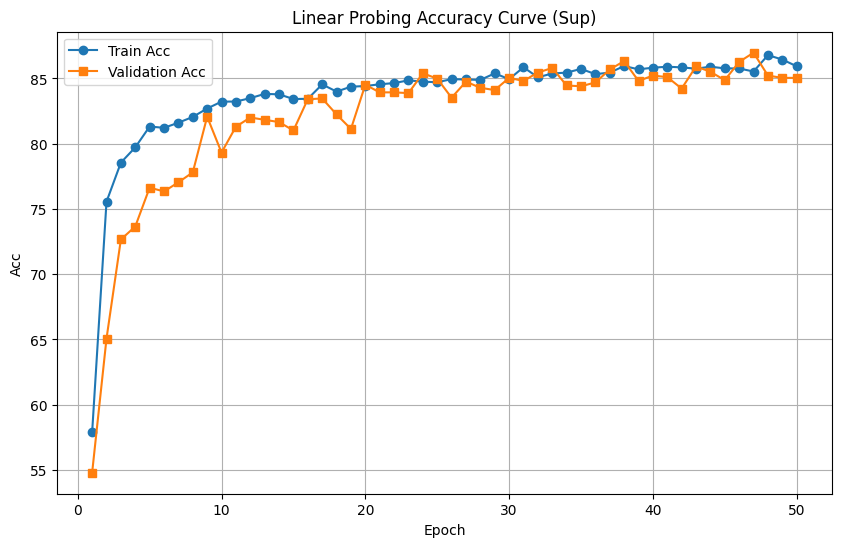

In [5]:
num_epochs = 50

train_acc_list = []
val_acc_list = []
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(sup_model, train_loader, criterion, optimizer, device)
    val_acc = validate(sup_model, val_loader, device)
    
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    
    print(f"[Epoch {epoch + 1}/{num_epochs}]: " + \
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Train Acc', marker='o')
plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label='Validation Acc', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Linear Probing Accuracy Curve (Sup)')
plt.legend()
plt.grid(True)

plt.show()

In [6]:
save_path = f"/h/lkcai/code/csc_pj_ckpts/bloodmnist_sup_lp_res50_{num_epochs}e.pth"
torch.save({
    'model_state_dict': sup_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': val_acc,
}, save_path)

In [12]:
eval_epoch_num = 50
save_path = f"/h/lkcai/code/csc_pj_ckpts/bloodmnist_sup_lp_res50_{eval_epoch_num}e.pth"

model = resnet50()
model.fc = nn.Linear(model.fc.in_features, 8)
model.fc.weight.data.normal_(mean=0.0, std=0.01)
model.fc.bias.data.zero_()

model.load_state_dict(torch.load(save_path)['model_state_dict'])
model = model.to(device)

val_acc = validate(model, val_loader, device)
print(f"ResNet18 without pretraining - Val Acc: {val_acc:.2f}% ")

test_acc = validate(model, test_loader, device)
print(f"ResNet18 without pretraining - Test Acc: {test_acc:.2f}% ")

ResNet18 without pretraining - Val Acc: 85.05% 
ResNet18 without pretraining - Test Acc: 84.92% 


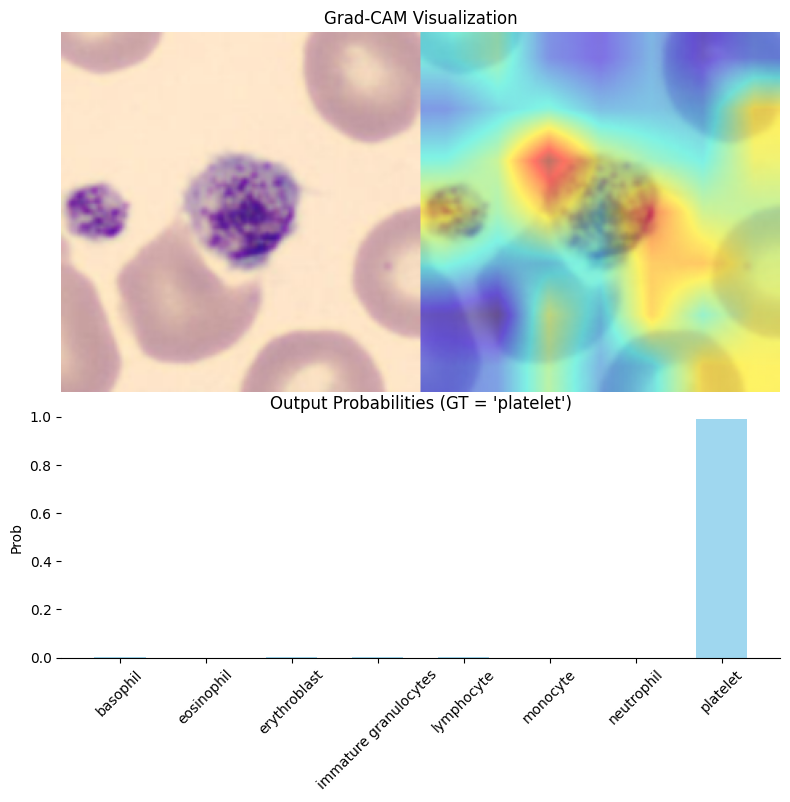

In [15]:
class_names = list(bloodmnist_label.values())

vis_res, output_probs, label = grad_cam_vis(model, val_loader, img_idx=2)

fig, axes = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 2]})

axes[0].imshow(vis_res)
axes[0].axis('off')
axes[0].set_title(f"Grad-CAM Visualization")

axes[1].bar(class_names, output_probs, color='skyblue', alpha=0.8, width=0.6)

axes[1].spines['left'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

axes[1].set_ylim([0, 1])
axes[1].set_ylabel("Prob")
axes[1].set_title(f"Output Probabilities (GT = '{class_names[label]}')")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('vis_results/cam_vis_sup_ft_res50.png')
plt.show()

# Finetune last linear layer with a self-supervised pretrained backbone (SimSiam)

In [3]:
"""
Download pre-trained SimSiam model from the following github repo:
https://github.com/facebookresearch/simsiam/tree/main
"""
simsiam_save_path = "/h/lkcai/code/csc_pj_ckpts/checkpoint_0099.pth.tar"
simsiam_state_dict = torch.load(simsiam_save_path)['state_dict']

new_state_dict = {k.replace('module.', ''): v for k, v in simsiam_state_dict.items()}
encoder_state_dict = {
    k.replace('encoder.', ''): v for k, v in new_state_dict.items() if k.startswith('encoder.')}

simsiam_model = resnet50()
simsiam_model.load_state_dict(encoder_state_dict, strict=False)

for name, param in simsiam_model.named_parameters():
    if name not in ["fc.weight", "fc.bias"]:
        param.requires_grad = False

simsiam_model.fc = nn.Linear(simsiam_model.fc.in_features, num_classes)
simsiam_model.fc.weight.data.normal_(mean=0.0, std=0.01)
simsiam_model.fc.bias.data.zero_()

criterion = nn.CrossEntropyLoss()

parameters = list(filter(lambda p: p.requires_grad, simsiam_model.parameters()))
optimizer = optim.Adam(parameters, 0.01)

simsiam_model = simsiam_model.to(device)

val_acc = validate(simsiam_model, val_loader, device)
print(f"Self-Sup Pretrained Classifier with Random head - Val Acc: {val_acc:.2f}% ")

Self-Sup Pretrained Classifier with Random head - Val Acc: 16.36% 


100%|██████████| 187/187 [01:19<00:00,  2.36it/s]


[Epoch 1/50]: Train Loss: 1.7975 Train Acc: 44.23% | Val Acc: 49.30%


100%|██████████| 187/187 [01:20<00:00,  2.34it/s]


[Epoch 2/50]: Train Loss: 1.4626 Train Acc: 61.93% | Val Acc: 58.29%


100%|██████████| 187/187 [01:19<00:00,  2.34it/s]


[Epoch 3/50]: Train Loss: 1.2405 Train Acc: 69.54% | Val Acc: 67.06%


100%|██████████| 187/187 [01:19<00:00,  2.36it/s]


[Epoch 4/50]: Train Loss: 1.0772 Train Acc: 75.32% | Val Acc: 72.84%


100%|██████████| 187/187 [01:19<00:00,  2.35it/s]


[Epoch 5/50]: Train Loss: 0.9633 Train Acc: 79.02% | Val Acc: 76.58%


100%|██████████| 187/187 [01:19<00:00,  2.35it/s]


[Epoch 6/50]: Train Loss: 0.8748 Train Acc: 80.82% | Val Acc: 80.08%


100%|██████████| 187/187 [01:19<00:00,  2.35it/s]


[Epoch 7/50]: Train Loss: 0.8118 Train Acc: 82.08% | Val Acc: 82.18%


100%|██████████| 187/187 [01:20<00:00,  2.34it/s]


[Epoch 8/50]: Train Loss: 0.7464 Train Acc: 83.51% | Val Acc: 83.76%


100%|██████████| 187/187 [01:19<00:00,  2.35it/s]


[Epoch 9/50]: Train Loss: 0.7026 Train Acc: 84.15% | Val Acc: 85.05%


100%|██████████| 187/187 [01:18<00:00,  2.39it/s]


[Epoch 10/50]: Train Loss: 0.6630 Train Acc: 84.72% | Val Acc: 85.57%


100%|██████████| 187/187 [01:18<00:00,  2.38it/s]


[Epoch 11/50]: Train Loss: 0.6322 Train Acc: 84.79% | Val Acc: 85.81%


100%|██████████| 187/187 [01:19<00:00,  2.34it/s]


[Epoch 12/50]: Train Loss: 0.6003 Train Acc: 85.68% | Val Acc: 87.03%


100%|██████████| 187/187 [01:19<00:00,  2.34it/s]


[Epoch 13/50]: Train Loss: 0.5819 Train Acc: 85.73% | Val Acc: 87.27%


100%|██████████| 187/187 [01:19<00:00,  2.35it/s]


[Epoch 14/50]: Train Loss: 0.5598 Train Acc: 86.16% | Val Acc: 88.08%


100%|██████████| 187/187 [01:17<00:00,  2.41it/s]


[Epoch 15/50]: Train Loss: 0.5436 Train Acc: 86.47% | Val Acc: 88.84%


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]


[Epoch 16/50]: Train Loss: 0.5305 Train Acc: 86.33% | Val Acc: 88.38%


100%|██████████| 187/187 [01:15<00:00,  2.49it/s]


[Epoch 17/50]: Train Loss: 0.5086 Train Acc: 87.37% | Val Acc: 88.43%


100%|██████████| 187/187 [01:14<00:00,  2.52it/s]


[Epoch 18/50]: Train Loss: 0.5005 Train Acc: 87.12% | Val Acc: 88.96%


100%|██████████| 187/187 [01:15<00:00,  2.49it/s]


[Epoch 19/50]: Train Loss: 0.4855 Train Acc: 87.01% | Val Acc: 89.49%


100%|██████████| 187/187 [01:13<00:00,  2.53it/s]


[Epoch 20/50]: Train Loss: 0.4728 Train Acc: 87.99% | Val Acc: 89.78%


100%|██████████| 187/187 [01:14<00:00,  2.53it/s]


[Epoch 21/50]: Train Loss: 0.4649 Train Acc: 87.53% | Val Acc: 89.25%


100%|██████████| 187/187 [01:13<00:00,  2.53it/s]


[Epoch 22/50]: Train Loss: 0.4561 Train Acc: 87.74% | Val Acc: 90.36%


100%|██████████| 187/187 [01:13<00:00,  2.53it/s]


[Epoch 23/50]: Train Loss: 0.4412 Train Acc: 88.39% | Val Acc: 90.36%


100%|██████████| 187/187 [01:13<00:00,  2.53it/s]


[Epoch 24/50]: Train Loss: 0.4402 Train Acc: 87.79% | Val Acc: 90.54%


100%|██████████| 187/187 [01:14<00:00,  2.51it/s]


[Epoch 25/50]: Train Loss: 0.4254 Train Acc: 88.49% | Val Acc: 90.60%


100%|██████████| 187/187 [01:13<00:00,  2.54it/s]


[Epoch 26/50]: Train Loss: 0.4207 Train Acc: 88.61% | Val Acc: 90.95%


100%|██████████| 187/187 [01:11<00:00,  2.60it/s]


[Epoch 27/50]: Train Loss: 0.4143 Train Acc: 88.48% | Val Acc: 91.06%


100%|██████████| 187/187 [01:11<00:00,  2.60it/s]


[Epoch 28/50]: Train Loss: 0.4117 Train Acc: 88.54% | Val Acc: 91.06%


100%|██████████| 187/187 [01:11<00:00,  2.61it/s]


[Epoch 29/50]: Train Loss: 0.4008 Train Acc: 88.65% | Val Acc: 91.00%


100%|██████████| 187/187 [01:11<00:00,  2.61it/s]


[Epoch 30/50]: Train Loss: 0.3908 Train Acc: 89.18% | Val Acc: 91.06%


100%|██████████| 187/187 [01:12<00:00,  2.59it/s]


[Epoch 31/50]: Train Loss: 0.3899 Train Acc: 89.05% | Val Acc: 91.71%


100%|██████████| 187/187 [01:11<00:00,  2.61it/s]


[Epoch 32/50]: Train Loss: 0.3818 Train Acc: 89.29% | Val Acc: 91.71%


100%|██████████| 187/187 [01:11<00:00,  2.60it/s]


[Epoch 33/50]: Train Loss: 0.3781 Train Acc: 89.62% | Val Acc: 91.65%


100%|██████████| 187/187 [01:12<00:00,  2.59it/s]


[Epoch 34/50]: Train Loss: 0.3828 Train Acc: 88.94% | Val Acc: 91.76%


100%|██████████| 187/187 [01:11<00:00,  2.61it/s]


[Epoch 35/50]: Train Loss: 0.3760 Train Acc: 89.01% | Val Acc: 91.94%


100%|██████████| 187/187 [01:12<00:00,  2.57it/s]


[Epoch 36/50]: Train Loss: 0.3709 Train Acc: 89.56% | Val Acc: 91.94%


100%|██████████| 187/187 [01:13<00:00,  2.54it/s]


[Epoch 37/50]: Train Loss: 0.3631 Train Acc: 89.74% | Val Acc: 92.17%


100%|██████████| 187/187 [01:13<00:00,  2.54it/s]


[Epoch 38/50]: Train Loss: 0.3536 Train Acc: 89.77% | Val Acc: 92.17%


100%|██████████| 187/187 [01:13<00:00,  2.54it/s]


[Epoch 39/50]: Train Loss: 0.3610 Train Acc: 89.61% | Val Acc: 92.00%


100%|██████████| 187/187 [01:13<00:00,  2.54it/s]


[Epoch 40/50]: Train Loss: 0.3542 Train Acc: 89.48% | Val Acc: 91.88%


100%|██████████| 187/187 [01:13<00:00,  2.54it/s]


[Epoch 41/50]: Train Loss: 0.3423 Train Acc: 90.22% | Val Acc: 91.94%


100%|██████████| 187/187 [01:13<00:00,  2.54it/s]


[Epoch 42/50]: Train Loss: 0.3381 Train Acc: 90.10% | Val Acc: 92.23%


100%|██████████| 187/187 [01:13<00:00,  2.53it/s]


[Epoch 43/50]: Train Loss: 0.3405 Train Acc: 89.99% | Val Acc: 92.52%


100%|██████████| 187/187 [01:13<00:00,  2.53it/s]


[Epoch 44/50]: Train Loss: 0.3322 Train Acc: 90.51% | Val Acc: 92.23%


100%|██████████| 187/187 [01:13<00:00,  2.55it/s]


[Epoch 45/50]: Train Loss: 0.3394 Train Acc: 90.18% | Val Acc: 92.46%


100%|██████████| 187/187 [01:13<00:00,  2.54it/s]


[Epoch 46/50]: Train Loss: 0.3326 Train Acc: 90.31% | Val Acc: 92.29%


100%|██████████| 187/187 [01:13<00:00,  2.53it/s]


[Epoch 47/50]: Train Loss: 0.3309 Train Acc: 90.20% | Val Acc: 92.41%


100%|██████████| 187/187 [01:13<00:00,  2.54it/s]


[Epoch 48/50]: Train Loss: 0.3293 Train Acc: 90.30% | Val Acc: 92.70%


100%|██████████| 187/187 [01:13<00:00,  2.54it/s]


[Epoch 49/50]: Train Loss: 0.3325 Train Acc: 90.37% | Val Acc: 92.87%


100%|██████████| 187/187 [01:12<00:00,  2.56it/s]


[Epoch 50/50]: Train Loss: 0.3248 Train Acc: 90.50% | Val Acc: 92.76%


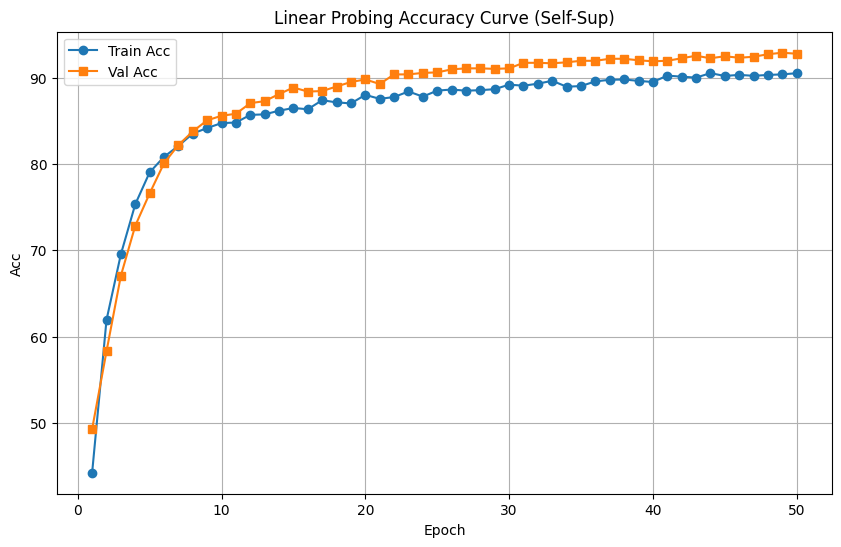

In [4]:
num_epochs = 50

train_acc_list = []
val_acc_list = []
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(simsiam_model, train_loader, criterion, optimizer, device)
    val_acc = validate(simsiam_model, val_loader, device)
    
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    
    print(f"[Epoch {epoch + 1}/{num_epochs}]: " + \
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Train Acc', marker='o')
plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label='Val Acc', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Linear Probing Accuracy Curve (Self-Sup)')
plt.legend()
plt.grid(True)

plt.show()

In [5]:
save_path = f"/h/lkcai/code/csc_pj_ckpts/bloodmnist_selfsup_lp_res50_{num_epochs}e.pth"
torch.save({
    'model_state_dict': simsiam_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': val_acc,
}, save_path)

In [16]:
eval_epoch_num = 50
save_path = f"/h/lkcai/code/csc_pj_ckpts/bloodmnist_selfsup_lp_res50_{eval_epoch_num}e.pth"

model = resnet50()
model.fc = nn.Linear(model.fc.in_features, 8)
model.fc.weight.data.normal_(mean=0.0, std=0.01)
model.fc.bias.data.zero_()

model.load_state_dict(torch.load(save_path)['model_state_dict'])
model = model.to(device)

val_acc = validate(model, val_loader, device)
print(f"ResNet50 Self-supervised linear probing - Val Acc: {val_acc:.2f}% ")

test_acc = validate(model, test_loader, device)
print(f"ResNet50 Self-supervised linear probing - Test Acc: {test_acc:.2f}% ")

ResNet50 Self-supervised linear probing - Val Acc: 92.76% 
ResNet50 Self-supervised linear probing - Test Acc: 92.49% 


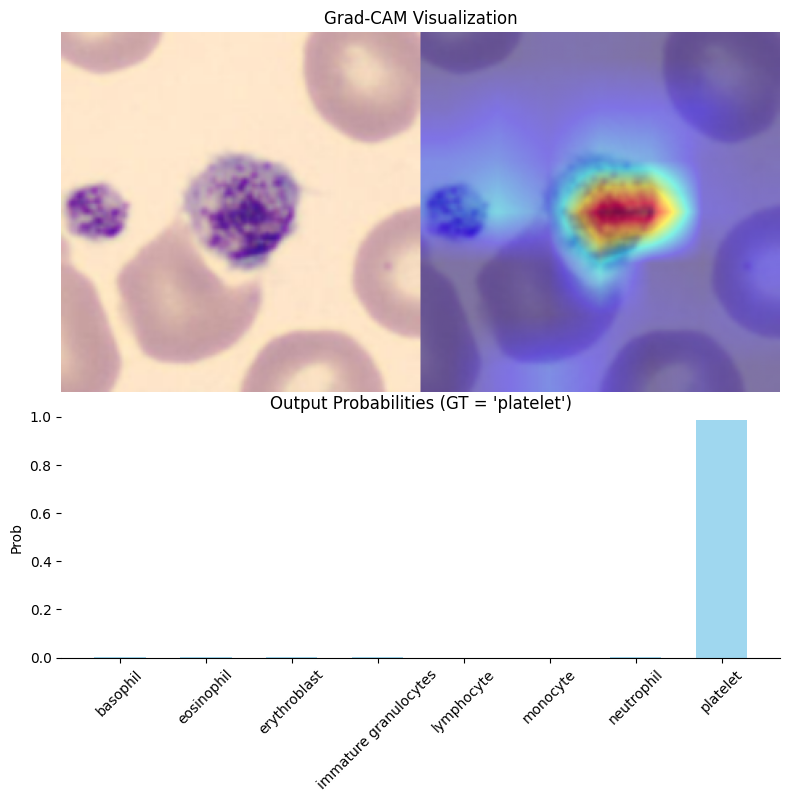

In [17]:
class_names = list(bloodmnist_label.values())

vis_res, output_probs, label = grad_cam_vis(model, val_loader, img_idx=2)

fig, axes = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 2]})

axes[0].imshow(vis_res)
axes[0].axis('off')
axes[0].set_title(f"Grad-CAM Visualization")

axes[1].bar(class_names, output_probs, color='skyblue', alpha=0.8, width=0.6)

axes[1].spines['left'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

axes[1].set_ylim([0, 1])
axes[1].set_ylabel("Prob")
axes[1].set_title(f"Output Probabilities (GT = '{class_names[label]}')")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('vis_results/cam_vis_selfsup_res50.png')
plt.show()